# **Customer Lifetime Value Prediction**🧑📈

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mlt
import warnings
warnings.filterwarnings('ignore')

In [3]:

df1 = pd.read_excel("data/online_retail_II.xlsx", sheet_name="Year 2009-2010")
df2 = pd.read_excel("data/online_retail_II.xlsx", sheet_name="Year 2010-2011")


df = pd.concat([df1, df2], ignore_index=True)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [7]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

# Data Cleaning✨

In [ ]:
# Remove rows with missing 'Customer ID' or 'Description'
df = df.dropna(subset=['Customer ID', 'Description'])

In [ ]:
# Remove cancelled transactions (Invoice starts with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

In [ ]:
# Correcting data types
df['Customer ID'] = df['Customer ID'].astype(int)

In [ ]:
# Remove non-positive quantities or prices
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [ ]:
# Create a TotalPrice column for future calculations
df['TotalPrice'] = df['Quantity'] * df['Price']

In [13]:
df = df.reset_index(drop=True)

In [14]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [21]:
df.to_csv('data/retail_cleaned_data.csv', index=False)

# Feature Engineerig

In [ ]:

# Define the cutoff date
cutoff_date = pd.to_datetime("2011-07-01")

df_past = df[df["InvoiceDate"] < cutoff_date].copy()
snapshot_date = df_past["InvoiceDate"].max() + pd.Timedelta(days=1)

# Group by customer and create aggregated features
features = df_past.groupby("Customer ID").agg({
    "InvoiceDate": [
        lambda x: (snapshot_date - x.max()).days,   # Recency
        lambda x: (snapshot_date - x.min()).days    # Tenure (customer age)
    ],
    "Invoice": "nunique",                           # Frequency
    "TotalPrice": "sum",                            # Monetary value
    "Quantity": "sum",                              # Total quantity bought
    "Price": "mean",                                # Avg unit price
    "Country": "first"                              # Country (optional)
})

features.columns = [
    "Recency", "Tenure", "Frequency", "TotalSpent",
    "TotalQuantity", "AvgUnitPrice", "Country"
]


features["AvgOrderValue"] = features["TotalSpent"] / features["Frequency"]
features["AvgQuantity"] = features["TotalQuantity"] / features["Frequency"]
features = features.reset_index()


In [16]:
features.head()

,Customer ID,Recency,Tenure,Frequency,TotalSpent,TotalQuantity,AvgUnitPrice,Country,AvgOrderValue,AvgQuantity
0,12346,164,564,12,77556.46,74285,6.100000,United Kingdom,6463.038333,6190.416667
1,12347,22,243,5,3529.27,2141,2.552717,Iceland,705.854000,428.200000
2,12348,87,277,4,1709.40,2497,3.137500,Finland,427.350000,624.250000
3,12349,246,428,3,2671.14,993,8.581765,Italy,890.380000,331.000000
4,12350,149,149,1,334.40,197,3.841176,Norway,334.400000,197.000000


In [17]:

cutoff_date = pd.to_datetime("2011-07-01")

df_past = df[df["InvoiceDate"] < cutoff_date].copy()

df_future = df[df["InvoiceDate"] >= cutoff_date].copy()


print("Transactions BEFORE cutoff:", df_past.shape[0])
print("Transactions AFTER cutoff:", df_future.shape[0])


Transactions BEFORE cutoff: 580299
Transactions AFTER cutoff: 225250


In [ ]:

cutoff_date = pd.to_datetime("2011-07-01")
date_3m = cutoff_date + pd.DateOffset(months=3)   # 2011-10-01
date_6m = cutoff_date + pd.DateOffset(months=6)   # 2012-01-01 (goes beyond data range, will still work)

df_future = df[df["InvoiceDate"] >= cutoff_date].copy()


label_3m = df_future[df_future["InvoiceDate"] < date_3m].groupby("Customer ID")["TotalPrice"].sum()
label_6m = df_future[df_future["InvoiceDate"] < date_6m].groupby("Customer ID")["TotalPrice"].sum()

features["CLV_3M"] = features["Customer ID"].map(label_3m)
features["CLV_6M"] = features["Customer ID"].map(label_6m)

features["CLV_3M"].fillna(0, inplace=True)
features["CLV_6M"].fillna(0, inplace=True)


# Model Training and Accuracy Calculation

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Select features and labels
X = features[[
    "Recency", "Tenure", "Frequency", "TotalSpent",
    "TotalQuantity", "AvgUnitPrice", "AvgOrderValue", "AvgQuantity"
]]

y_3m = features["CLV_3M"]
y_6m = features["CLV_6M"]

# Split into train and test sets
X_train_3m, X_test_3m, y_train_3m, y_test_3m = train_test_split(X, y_3m, test_size=0.2, random_state=42)
X_train_6m, X_test_6m, y_train_6m, y_test_6m = train_test_split(X, y_6m, test_size=0.2, random_state=42)

# Train XGBoost Regressors
model_3m = XGBRegressor(objective='reg:squarederror', random_state=42)
model_6m = XGBRegressor(objective='reg:squarederror', random_state=42)

model_3m.fit(X_train_3m, y_train_3m)
model_6m.fit(X_train_6m, y_train_6m)

# Evaluate the models
y_pred_3m = model_3m.predict(X_test_3m)
y_pred_6m = model_6m.predict(X_test_6m)


# Accuracy Calculation
rmse_3m = np.sqrt(mean_squared_error(y_test_3m, y_pred_3m))
rmse_6m = np.sqrt(mean_squared_error(y_test_6m, y_pred_6m))

r2_3m = r2_score(y_test_3m, y_pred_3m)
r2_6m = r2_score(y_test_6m, y_pred_6m)

print(f"3M RMSE: {rmse_3m:.2f}, R²: {r2_3m:.2f}")
print(f"6M RMSE: {rmse_6m:.2f}, R²: {r2_6m:.2f}")


3M RMSE: 3418.05, R²: 0.44
6M RMSE: 5357.62, R²: 0.56


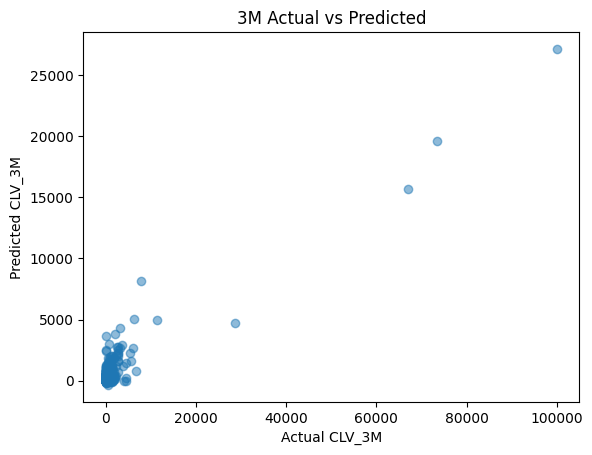

In [25]:
import matplotlib.pyplot as plt

plt.scatter(y_test_3m, y_pred_3m, alpha=0.5)
plt.xlabel("Actual CLV_3M")
plt.ylabel("Predicted CLV_3M")
plt.title("3M Actual vs Predicted")
plt.show()


In [23]:
features.to_csv('data/features.csv',index=False)

In [24]:
import joblib

# Save the models
joblib.dump(model_3m, "models/clv_model_3m.pkl")
joblib.dump(model_6m, "models/clv_model_6m.pkl")


['models/clv_model_6m.pkl']